# Deep Neural Network

In [1]:
# Import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from tqdm import tqdm
from IPython.display import display

from data_processing import prepare_data, split_data
from helper_functions import get_metrics

import tensorflow as tf
from tensorflow.keras import layers, models, preprocessing, Input, metrics
from tensorflow.keras.metrics import FalsePositives, TruePositives, FalseNegatives, TrueNegatives

from sklearn.metrics import balanced_accuracy_score, accuracy_score, confusion_matrix


In [2]:
# Get the data and clean it
data = prepare_data('healthcare-dataset-stroke-data.csv')

# Split the data into test, training and validation data
train_data, test_data, val_data, train_labels, test_labels, val_labels = split_data(data, split_size=(0.6, 0.2, 0.2))

### Milestone 1: Basic model

Train on 3065 samples, validate on 1022 samples
Epoch 1/30
3065/3065 [==============================] - 2s 577us/sample - loss: 0.4307 - accuracy: 0.8715 - val_loss: 0.2533 - val_accuracy: 0.9511
Epoch 2/30
3065/3065 [==============================] - 0s 118us/sample - loss: 0.2073 - accuracy: 0.9514 - val_loss: 0.1890 - val_accuracy: 0.9511
Epoch 3/30
3065/3065 [==============================] - 0s 103us/sample - loss: 0.1777 - accuracy: 0.9514 - val_loss: 0.1786 - val_accuracy: 0.9511
Epoch 4/30
3065/3065 [==============================] - 0s 104us/sample - loss: 0.1686 - accuracy: 0.9514 - val_loss: 0.1726 - val_accuracy: 0.9511
Epoch 5/30
3065/3065 [==============================] - 0s 109us/sample - loss: 0.1632 - accuracy: 0.9514 - val_loss: 0.1686 - val_accuracy: 0.9511
Epoch 6/30
3065/3065 [==============================] - 0s 111us/sample - loss: 0.1592 - accuracy: 0.9514 - val_loss: 0.1670 - val_accuracy: 0.9511
Epoch 7/30
3065/3065 [==============================] - 0s 153us

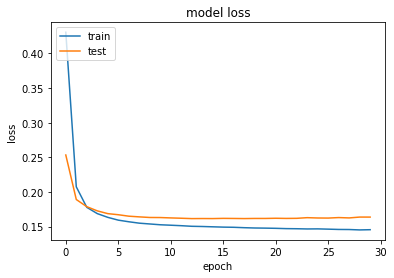

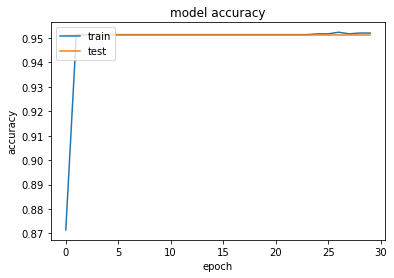

train metrics: 

accuracy: 95.2039 % 

balanced accuracy: 50.6711 %
sensitivity: 0.0134
specificity: 1.0000 

confusion matrix: 
[[2916    0]
 [ 147    2]] 

[["True Negative", "False Positive"] 
 ["False Negative", "True Positive"]] 

test metrics: 

accuracy: 95.1076 % 

balanced accuracy: 50.0000 %
sensitivity: 0.0000
specificity: 1.0000 

confusion matrix: 
[[972   0]
 [ 50   0]] 

[["True Negative", "False Positive"] 
 ["False Negative", "True Positive"]] 



In [3]:
def train_and_predict(model, training_data, training_labels, testing_data, testing_labels, epochs=5):
    """
    This function trains a given neural network model based on training data and training labels. It then predicts classes on
    training and testing data. It is possible to adjust for how many epochs the model is trained
    """
    # Compile the layers of the model defined earlier. Use the binary cross entropy function as the loss function as we only
    # have 2 output classes and use accuracy as the metric
    model.compile(loss='binary_crossentropy', metrics=['accuracy'])
    
    # Train the model for a number of epochs
    history = model.fit(training_data, training_labels, epochs=epochs, validation_data=(testing_data, testing_labels))

    # Predict the classes of the training data
    predictions_train = model.predict(training_data) >= 0.5
    
    # Predict the classes on the testing data
    predictions_test = model.predict(testing_data) >= 0.5
    
    # Plot the accuracy over epochs
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

    plt.show()

    return predictions_train, predictions_test

# Get the amount of input features for the nodes in the first layer
input_shape = np.shape(train_data)[1]

# Create the model
model = models.Sequential()

# First layer with input nodes equal to features
model.add(Input(shape=(input_shape)))

# One hidden layer with 25 nodes
model.add(layers.Dense(25, activation='relu'))

# Output layer with 1 node (only 1 output class, 0 or 1 for stroke) and sigmoid activation function
model.add(layers.Dense(1, 'sigmoid'))

# Train and predict
predictions_train, predictions_test = train_and_predict(model, train_data, 
                                                        train_labels, test_data, test_labels,
                                                        epochs=30)

# Print metrics
print('train metrics: \n')
accuracy_train, balanced_accuracy_train = get_metrics(train_labels, predictions_train, verbose=True)

print('test metrics: \n')
accuracy_test, balanced_accuracy_test = get_metrics(test_labels, predictions_test, verbose=True)



### Milestone 2: Actual model
##### Additions:
1. Weighted loss to increase sensitivity to stroke cases.
2. Added more metrics

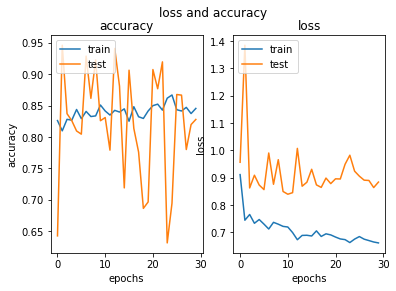

train metrics: 

accuracy: 83.9334 % 

balanced accuracy: 71.2293 %
sensitivity: 0.5737704918032787
specificity: 0.8508150248051027 

confusion matrix: 
[[2401  421]
 [  52   70]] 

[["True Negative", "False Positive"] 
 ["False Negative", "True Positive"]] 

test metrics: 

accuracy: 82.7902 % 

balanced accuracy: 70.5366 %
sensitivity: 0.5686274509803921
specificity: 0.8421052631578947 

confusion matrix: 
[[784 147]
 [ 22  29]] 

[["True Negative", "False Positive"] 
 ["False Negative", "True Positive"]] 



In [136]:
def train_and_predict(model, training_data, training_labels, 
                      testing_data, testing_labels, epochs=5, 
                      class_weight=10, verbose=0, plot=True):
    """
    This function trains a given neural network model based on training data and training labels. It then predicts classes on
    training and testing data. 
    It is possible to adjust for how many epochs the model is trained and how to weight the sparse class.
    
    input:
    
    model:        model architecture defined before calling this function
    class_weight:  errors on the stroke class should be weighted heavier then the non-stroke class. 
                  The value defines how much more this loss is weighted. loss_weight=10 means a ratio of 1 to 10.
                  For some reason
    verbose:      0: no text per epoch
                  1: text for each epoch
    plot:         True: show accuracy and loss over epochs in figure
                  False: no plot
                  
    output: 
    
    predictions_train: vector of training predictions
    predictions_test:  vector of test predictions
    history:           dict containing measures over epochs, including loss, accuracy, TP, FP, TN, FN, for train and test data.
                       print history.history for all measures and their keys.
    
    """
    # extra metrics to store after each epoch, useful for keeping track during epochs:
    TP = TruePositives()
    FP = FalsePositives()
    TN = TrueNegatives()
    FN = FalseNegatives()
    
    # Compile the layers of the model defined earlier. Use the binary cross entropy function as the loss function as we only
    # have 2 output classes and use accuracy as the metric
    model.compile(loss='binary_crossentropy', metrics=['accuracy', TP, FP, TN, FN])
    
    # set warnings off (annoying bug in tensorflow)
    tf.get_logger().setLevel('ERROR')
    # Train the model for a number of epochs
    history = model.fit(training_data, training_labels, epochs=epochs, 
                        validation_data=(testing_data, testing_labels),
                        class_weight=[{0: 1., 1: class_weight}],
                        #sample_weight=[None],
                        verbose=verbose
                       )
    # set warnings on again 
    tf.get_logger().setLevel('INFO')

    # Predict the classes of the training data
    predictions_train = model.predict(training_data) >= 0.5
    
    # Predict the classes on the testing data
    predictions_test = model.predict(testing_data) >= 0.5
    
    # Plot the loss and accuracy over epochs.
    if plot:
        fig, axs = plt.subplots(1, 2)
        fig.suptitle('loss and accuracy')
    
        axs[0].plot(history.history['accuracy'])
        axs[0].plot(history.history['val_accuracy'])
        axs[0].legend(['train', 'test'], loc='upper left')
        axs[0].set_title('accuracy')
        axs[0].set_ylabel('accuracy')
        axs[0].set_xlabel('epochs')


        # Plot the loss over epochs
        axs[1].plot(history.history['loss'])
        axs[1].plot(history.history['val_loss'])
        axs[1].set_title('loss')
        axs[1].set_xlabel('epochs')
        axs[1].set_ylabel('loss')
        axs[1].legend(['train', 'test'], loc='upper left')

    
    plt.show()

    return predictions_train, predictions_test, history

# Get the amount of input features for the nodes in the first layer
input_shape = np.shape(train_data)[1]

# Create the model
model = models.Sequential()

# First layer with input nodes equal to features
model.add(Input(shape=(input_shape)))

# One hidden layer with 25 nodes
model.add(layers.Dense(20, activation='relu'))

#model.add(layers.Dense(20, activation='relu'))

model.add(layers.Dense(5, activation='relu'))

# Output layer with 1 node (only 1 output class, 0 or 1 for stroke) and sigmoid activation function
model.add(layers.Dense(1, 'sigmoid'))

# Train and predict
predictions_train, predictions_test, history = train_and_predict(model, train_data, 
                                                        train_labels, test_data, test_labels,
                                                        class_weight = 10,
                                                        epochs=30, verbose=0)

# Print metrics
print('train metrics: \n')
accuracy_train, balanced_accuracy_train = get_metrics(train_labels, predictions_train, verbose=True)

print('test metrics: \n')
accuracy_test, balanced_accuracy_test = get_metrics(test_labels, predictions_test, verbose=True)



100%|██████████| 15/15 [01:23<00:00,  5.59s/it]


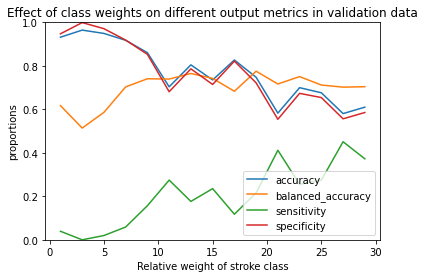

In [133]:
# Test different class weights and plot accuracy and sensitivity
# For now, ignore the warning.

accuracies_val = []
sensitivities_val = []
balanced_accuracies_val = []
specificities_val = []
for i in tqdm(range(1, 30, 2)):
    # Train and predict
    predictions_train, predictions_val, history = train_and_predict(model, train_data, 
                                                          train_labels, val_data, val_labels,
                                                          epochs=30, verbose=0, plot=False,
                                                          class_weight=i)
    
    # metrics
    accuracy_val, balanced_accuracy_val = get_metrics(val_labels, predictions_val, verbose=False)
    conmat = confusion_matrix(test_labels, predictions_val)
    sensitivity = conmat[1,1] / sum(conmat[1,:])
    specificity = conmat[0,0] / sum(conmat[0,:])

    accuracies_val.append(accuracy_val)
    balanced_accuracies_val.append(balanced_accuracy_val)
    sensitivities_val.append(sensitivity)
    specificities_val.append(specificity)
    
## Plot metrics over  class weights.

plt.plot(range(1,30,2), accuracies_val)
plt.plot(range(1,30,2), balanced_accuracies_val)
plt.plot(range(1,30,2), sensitivities_val)
plt.plot(range(1,30,2), specificities_val)
plt.ylim(0, 1)
plt.title('Effect of class weights on different output metrics in validation data')
plt.ylabel('proportions')
plt.xlabel('Relative weight of stroke class')
plt.legend(['accuracy', 'balanced_accuracy', 'sensitivity', 'specificity'])
plt.show()  


    
